In [68]:
import cv2
import numpy as np
import math
from sklearn import mixture
from scipy import linalg
import itertools
import matplotlib.pyplot as plt
from scipy import linalg
import matplotlib as mpl
from time import time
# from scipy import infty
from sklearn import preprocessing
from sklearn.utils import shuffle
# from matplotlib import colors as mcolors
# from scipy.misc import imfilter, imread
# from skimage import color, data, restoration
# from scipy.signal import convolve2d as conv2
# import matplotlib.cm as cm
from itertools import chain
from skimage import feature

#-----Define Helper Functionas------#

#---------Loads Each Image and Runs GMM Fit---------

color_iter = itertools.cycle(['navy', 'red', 'cornflowerblue', 'gold', 'darkorange','b','cyan'])


# dictionary of color codes for creating segmentation masks
_color_codes = {
    1: (171,166, 27),
    2: (112, 26, 91,),
    3: (61, 42,   61), 
    4: (19, 118, 140),
    5: (227, 25, 227),
    6: (139, 69,   19),
    7: (56, 161,  48)
}
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.9, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.title('Output')


def test(imtest, gmm, dpgmm):
    lab1=gmm.predict(imtest)
    lab2=dpgmm.predict(imtest)

    # plot_results(imtest, lab1, gmm.means_, gmm.covariances_, 0 ,'Gaussian Mixture')
    # plot_results(imtest, lab2, dpgmm.means_, dpgmm.covariances_, 1 ,'Bayesian Gaussian Mixture with a Dirichlet process prior')
    # plt.show()
	
    return lab1,lab2

#---------Runs GMM Fit on Each Random Combination of 1000 Points, 'num_patches' number of times---------#

def train(num_patches, image,n_samples,w,h):
	for i in range(1, num_patches): 
		imtrain = shuffle(image)
		imtrain=imtrain[:1000]
		gmm = mixture.GaussianMixture(n_components=7, covariance_type='full',  tol=0.001, reg_covar=1e-06, max_iter=1200, n_init=1, init_params='kmeans',  warm_start=True).fit(imtrain)
		dpgmm = mixture.BayesianGaussianMixture(n_components=7, covariance_type='full', weight_concentration_prior_type='dirichlet_distribution', tol=0.001, reg_covar=1e-06, max_iter=1200, n_init=1, init_params='kmeans', warm_start=True).fit(imtrain)
		return gmm, dpgmm


def segmented(image,samples,label, num_comp):
    #Add dimension to [n,] array
	labels=np.expand_dims(label, axis=0)
	labels=np.transpose(labels)

	for i in range(1,num_comp):

		indices=np.where(np.all(labels==i, axis=-1))
		indices = np.unravel_index(indices, (w,h), order='C')
		type(indices)
		indices=np.transpose(indices)

		#indices=list(indices)
		l = chain.from_iterable(zip(*indices))

		for j, (lowercase, uppercase) in enumerate(l):
        		# set the colour accordingly

				image[lowercase,uppercase] = _color_codes[(i)]

	return image

def createData(image, n_samples):
	#Intialisation for Local Binary Patterns Descriptor
	numPoints = 24
	#Number of samples per component
	radius = 8
	img_src = cv2.GaussianBlur(image,(5,5),0)

	#blur = cv2.bilateralFilter(img_src,9,75,75)
	#blurthresh=100
	#imtest = fix(imtest, blurthresh)

	imtest=cv2.cvtColor(img_src, cv2.COLOR_BGR2LAB)
	img_gray= cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

	lbp = feature.local_binary_pattern(img_gray, numPoints,
		radius, method="uniform")

	lbp=np.reshape(lbp,(n_samples,1))

	imtest= np.reshape(imtest, (n_samples, d))
	data=np.column_stack((imtest, lbp))

	data= preprocessing.normalize(imtest, norm= 'l2')
	#data= preprocessing.scale(data);

	return data, imtest



In [69]:
#LoadImage
img_src = cv2.imread('../input/13.jpg')
w, h, d = original_shape = tuple(img_src.shape)
assert d == 3

# Number of samples per component
n_samples = w*h
#Number of sets of training samples
num_patches=100;


samples, imtest=createData(img_src, n_samples)
gmm, dpgmm=train(num_patches, samples ,n_samples,w,h)
lab1,lab2=test(samples, gmm, dpgmm)
seg1=segmented(img_src,samples,lab1, 7)
seg2=segmented(img_src,samples, lab2,7)




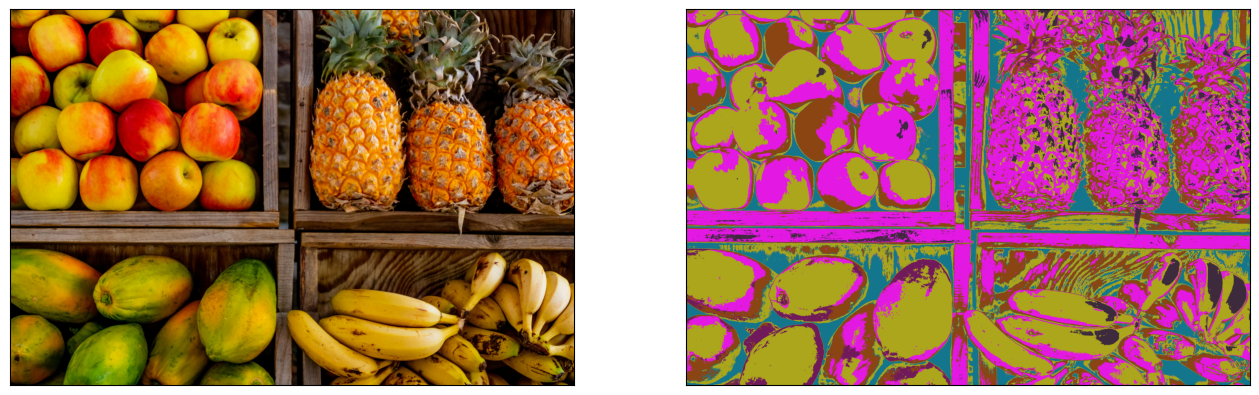

In [70]:
import matplotlib.image as mpimg
img_src = mpimg.imread('../input/13.jpg') 


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
axs[0].imshow(img_src)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(seg1)
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.imsave('../output/13.png', seg1)